Cascade Adaboost 예제
임의로 생성된 데이터로 케스케이드 에이다부스트 적용


In [1]:

import numpy as np
import matplotlib.pyplot as plt #데이타 시각화할때 필요한 라이브러리, 그래프 그리는 라이브러리
from sklearn.ensemble import AdaBoostClassifier #에이다부스트
from sklearn.tree import DecisionTreeClassifier #결정트리구조
from sklearn.model_selection import train_test_split #훈련세트하고 테스트 세트 분리해주는 함수
from sklearn.datasets import make_classification #make_classfication 분류 문제를 임의로 생성
from sklearn.decomposition import PCA #PCA: 주성분 분석 principal component analysis: 여러변수가 있으면 그 중 중요한 변수만 추출 -> 차원 축소 가능
from sklearn.metrics import accuracy_score # 정확도 계산 함수 읽어오기

# 데이터셋 생성
#make_classification 분류 데이터 샘플
#생성 n_sample 1000 -> 샘플 개수 1000개
#n_features =20 random_state=42
# 특성의 개수가 20, 랜덤 스테이트 42인 데이터를 가져온다
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# 학습용 및 테스트용 데이터 분할
# train_test_split 데이터 세트 분할 -> 학습용 테스트용
# 80%가 학습용 20%가 테스트  test_size=0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


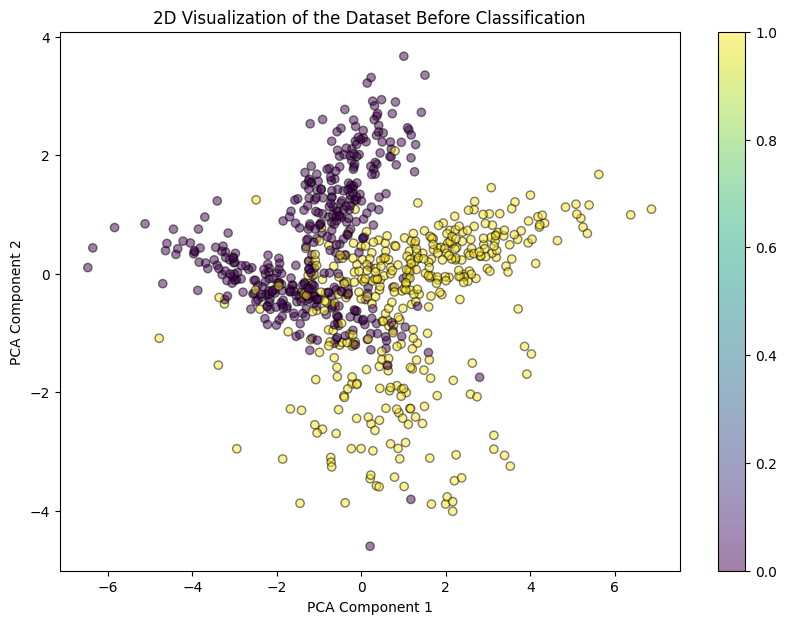

In [2]:
# PCA를 사용하여 2차원으로 축소 (시각화를 위해)
pca = PCA(n_components=2)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# 데이터 시각화 (분류 전)
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y_train, cmap='viridis', alpha=0.5, edgecolor='k')
plt.colorbar(scatter)
plt.title("2D Visualization of the Dataset Before Classification")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [3]:
# 기본 학습기 정의
# 결정 트리 구조, 깊이가 1. 
base_estimator = DecisionTreeClassifier(max_depth=1)

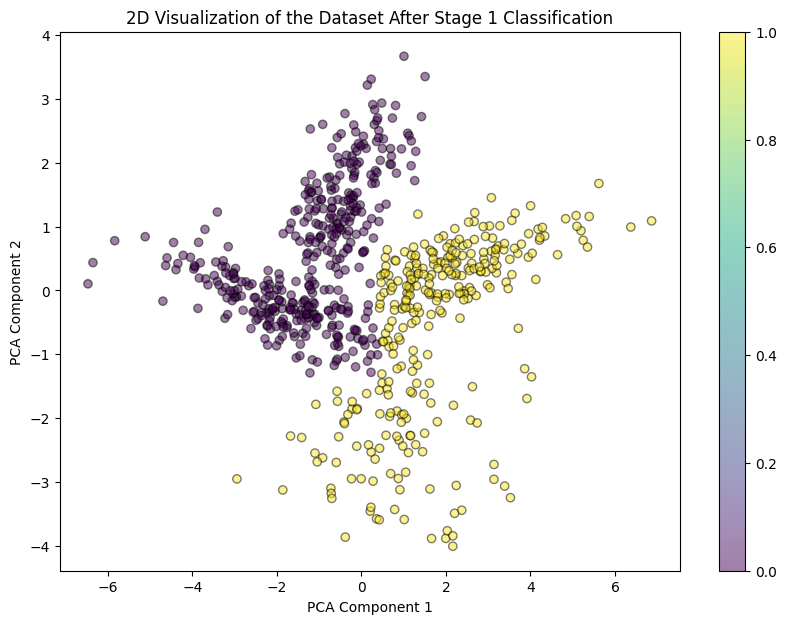

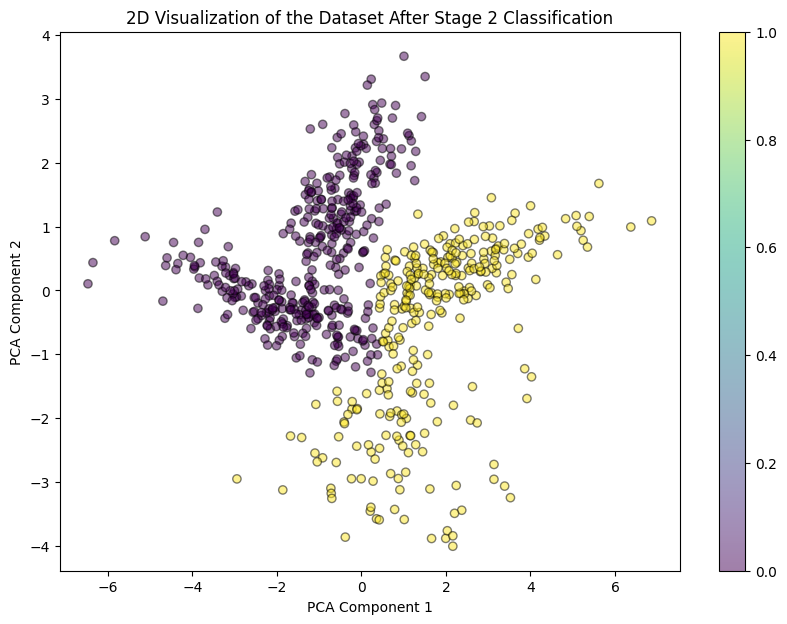

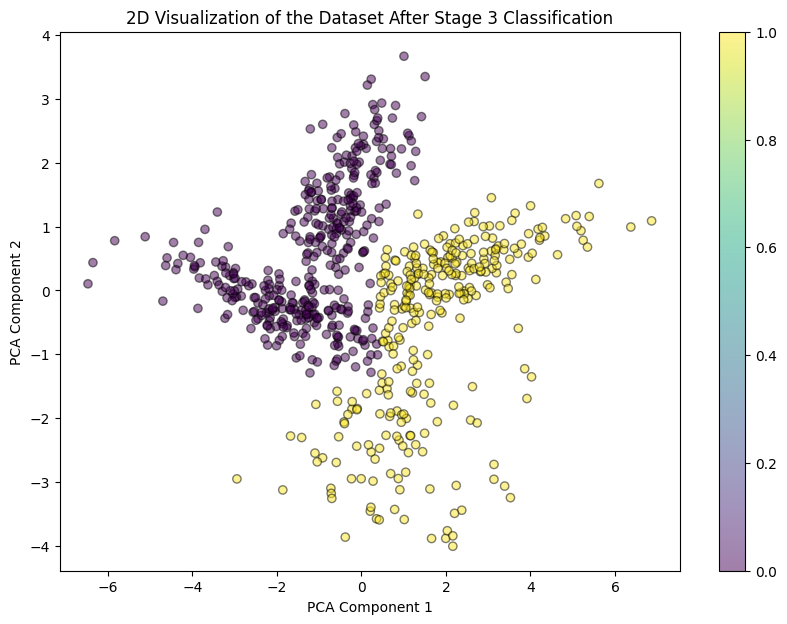

In [4]:
# cascade_stages = []  <- 비어 있는 리스트 배열 만듦
cascade_stages = [] 
# range(3) cascade를 3번 하겠다는 말
for stage in range(3):
    model = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42, algorithm='SAMME')
    model.fit(X_train_reduced, y_train)
    cascade_stages.append(model)
    # 긍정 예제 필터링 (예제 코드에서는 간략화)
    positive_indices = model.predict(X_train_reduced) == y_train
    X_train_reduced, y_train = X_train_reduced[positive_indices], y_train[positive_indices]

    # 단계별 학습 데이터 시각화
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y_train, cmap='viridis', alpha=0.5, edgecolor='k')
    plt.colorbar(scatter)
    plt.title(f"2D Visualization of the Dataset After Stage {stage+1} Classification")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()



In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
step = [1, 10, 50]

for idx, model in enumerate(cascade_stages):
    # 결정 경계 시각화
    x_min, x_max = X_train_reduced[:, 0].min() - 1, X_train_reduced[:, 0].max() + 1
    y_min, y_max = X_train_reduced[:, 1].min() - 1, X_train_reduced[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    scatter = axes[idx].scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y_train, cmap='viridis', edgecolor='k')
    axes[idx].set_title(f'Stage: {idx+1}')
    axes[idx].set_xlabel('PCA Component 1')
    axes[idx].set_ylabel('PCA Component 2')

plt.colorbar(scatter, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
plt.show()

In [ ]:
# 최종 검출
weighted_votes = np.zeros((X_test_reduced.shape[0], len(np.unique(y_train))))

for model in cascade_stages:
    predictions = model.predict(X_test_reduced)
    for i in range(len(predictions)):
        weighted_votes[i, predictions[i]] += model.estimator_weights_.sum()

final_predictions = np.argmax(weighted_votes, axis=1)

accuracy = accuracy_score(y_test, final_predictions)
print(f'Cascade AdaBoost Accuracy: {accuracy:.2f}')